In [11]:
import requests
import json
import pandas as pd
import numpy as np
from time import sleep
from datetime import datetime, timezone
from datetime import time



import matplotlib.pyplot as plt
import matplotlib

from utils import get_block_number_from_timestamp


# Create timestamp - block dataframe
- Timestamp to block_number, closest = before that timestamp, with API from polygonscan, save it to csv to use later
- If timestamp - block number exist, dont repeat API call, polygonscan has limitted api call
- block will be use to query ocean-subgraph later
- Queried every 6 hours, this is also an interval for all historical data queries: global statistics, pools, fixed rate exchange

Load previously fetched data

In [48]:
df_timestamp_block_origin = pd.read_csv('./daily_data/timestamp_block.csv')

print("Origin date fetch (UTC):", datetime.utcfromtimestamp(df_timestamp_block_origin['timestamp'].iloc[-1]))


Origin date fetch: 2022-07-20 00:00:00


Fetch new timestamp-block

In [49]:
# work well for timezone that is ahead of UTC
origin_timestamp = df_timestamp_block_origin['timestamp'].iloc[-1]
dt = datetime.now()
last_timestamp = int(datetime(
    year=dt.year, month=dt.month, day=dt.day, 
    hour=0, minute=0, second=0, microsecond=0, 
    tzinfo=timezone.utc
).timestamp())

interval = 86400 # 1 day
df_timestamp_block = df_timestamp_block_origin

for timestamp in range(origin_timestamp, last_timestamp+1, interval):
    block = get_block_number_from_timestamp(timestamp)
    values = [{
        "timestamp": timestamp,
        "block": block
    }]
    df_timestamp_block = df_timestamp_block.append(values)
    sleep(0.25)

# save
df_timestamp_block.reset_index(inplace = True, drop = True)
df_timestamp_block.to_csv('./daily_data/timestamp_block.csv', index=False)

print("Last date fetch (UTC):", datetime.utcfromtimestamp(df_timestamp_block['timestamp'].iloc[-1]))


Last date fetch: 2022-07-28 00:00:00


# Global statistics
- Overall Ocean markerplace information, including

In [67]:
df_global_statistics =  pd.read_csv('./daily_data/global_statistics.csv')

base_url = "https://v4.subgraph.polygon.oceanprotocol.com"
route = "/subgraphs/name/oceanprotocol/ocean-subgraph"
url = base_url + route

for i in range(df_timestamp_block_origin.shape[0], df_timestamp_block.shape[0], 1): 
  block = df_timestamp_block['block'][i]
  timestamp = df_timestamp_block['timestamp'][i]
  query = \
  f"""
    {{
      globalStatistics (
        block: {{
          number: {block}
        }}
      ) 
      {{
        nftCount
        datatokenCount
        totalLiquidity {{
          value
          token {{
            address
          }}
        }}
        poolCount
        fixedCount
      }}
    }}
  """
  headers = {"Content-Type": "application/json"}
  payload = json.dumps({"query": query})
  response = requests.request("POST", url, headers=headers, data=payload)
  data = json.loads(response.text)

  df_data = pd.json_normalize(
    data['data']['globalStatistics'],
    record_path=['totalLiquidity'],
    meta=['datatokenCount','fixedCount','nftCount','poolCount']
  )
  df_data.rename({'value': 'totalLiquidity.value', 'token.address': 'totalLiquidity.token.address'}, axis=1, inplace=True)
  
  df_data['block'] = block
  df_data['timestamp'] = timestamp

  df_global_statistics = pd.concat([df_global_statistics, df_data], ignore_index=True, sort=False)

df_global_statistics.to_csv('./daily_data/global_statistics.csv', index=False)

In [66]:
df_global_statistics =  pd.read_csv('./daily_data/global_statistics.csv')
df_global_statistics.shape

(43, 8)

In [69]:
df_global_statistics =  pd.read_csv('./daily_data/global_statistics.csv')
df_global_statistics['timestamp'].iloc[-1]

1658966400

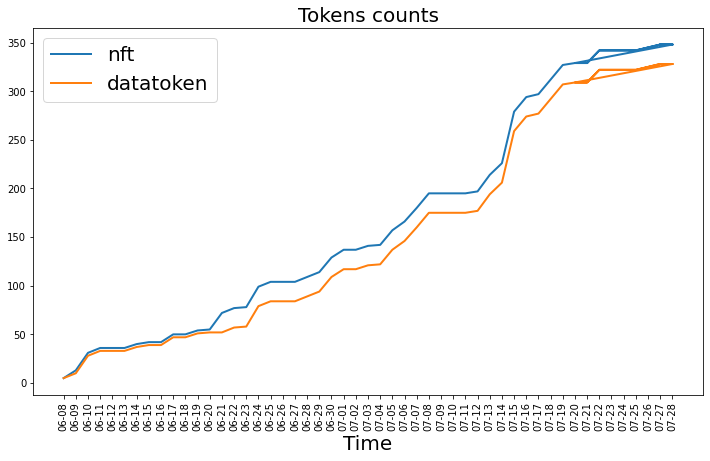

In [71]:
fig, ax = plt.subplots()
x = pd.to_datetime(df_global_statistics["timestamp"], unit='s').dt.strftime('%m-%d')

y = df_global_statistics['nftCount'].astype(float)
plt.plot(x, y, label = 'nft', linewidth=2)

y = df_global_statistics['datatokenCount']
plt.plot(x, y, label = 'datatoken', linewidth=2)


plt.xlabel("Time", fontsize=20)
# plt.ylabel("Number of tokens", fontsize=16)
plt.title(f"Tokens counts", fontsize=20)
plt.xticks(rotation=30)
plt.legend(fontsize=20)

ax.tick_params(axis='x',rotation=90)

# ax.set_xticks(x[0::8])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6.75)

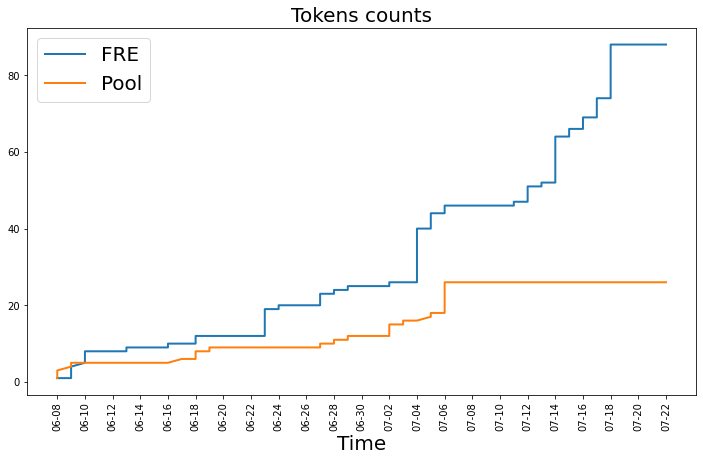

In [18]:
fig, ax = plt.subplots()
x = pd.to_datetime(df_global_statistics["timestamp"], unit='s').dt.strftime('%m-%d')

y = df_global_statistics['fixedCount'].astype(float)
plt.plot(x, y, label = 'FRE', linewidth=2)

y = df_global_statistics['poolCount']
plt.plot(x, y, label = 'Pool', linewidth=2)


plt.xlabel("Time", fontsize=20)
# plt.ylabel("Number of tokens", fontsize=16)
plt.title(f"Tokens counts", fontsize=20)
plt.xticks(rotation=30)
plt.legend(fontsize=20)

ax.tick_params(axis='x',rotation=90)

ax.set_xticks(x[0::8])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6.75)

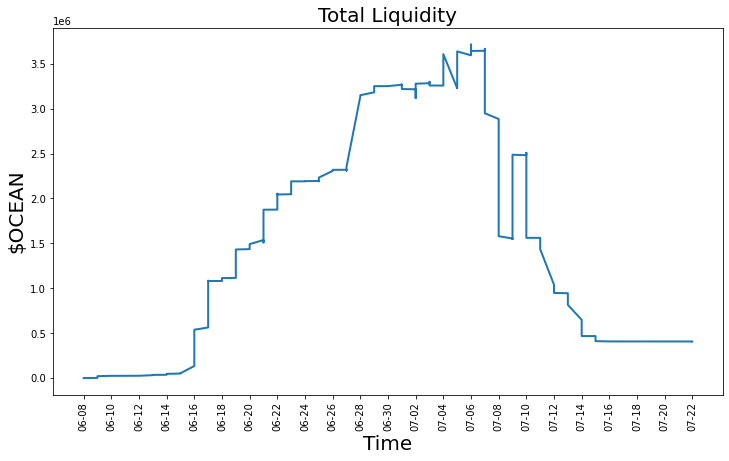

In [5]:
fig, ax = plt.subplots()
x = pd.to_datetime(df_global_statistics["timestamp"], unit='s').dt.strftime('%m-%d')

y = df_global_statistics['totalLiquidity.value'].astype(float)
plt.plot(x, y, label = 'Total Liquidity', linewidth=2)


plt.xlabel("Time", fontsize=20)
plt.ylabel("$OCEAN", fontsize=20)
plt.title(f"Total Liquidity", fontsize=20)
plt.xticks(rotation=30)
# plt.legend(fontsize=10)

ax.tick_params(axis='x',rotation=90)

ax.set_xticks(x[0::8])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6.75)

# Datatokens

## Query

In [51]:
# query = \
# """
# {
#   tokens (
#     where: {isDatatoken: true}
#     orderBy: createdTimestamp
#     orderDirection:asc
#     first: 1000
#   ) 
#   {
#     address
#     createdTimestamp
#     block
#     pools {
#       id
#     }
#     fixedRateExchanges {
#       id
#     }
#   }
# }
 
# """
# headers = {"Content-Type": "application/json"}
# payload = json.dumps({"query": query})
# response = requests.request("POST", url, headers=headers, data=payload)

# data = json.loads(response.text)
# df_datatokens = pd.json_normalize(data['data']['tokens'])

## Clean

In [52]:
# df_datatokens['fixedRateExchanges'] = df_datatokens['fixedRateExchanges'].apply(lambda y: y[0]['id'] if len(y)>0 else np.nan)
# df_datatokens['pools'] = df_datatokens['pools'].apply(lambda y: y[0]['id'] if len(y)>0 else np.nan)
# df_datatokens.to_csv('./data/datatokens.csv', index=False)

In [6]:
df_datatokens = pd.read_csv('./data/datatokens.csv')
df_datatokens.head()

,address,block,createdTimestamp,fixedRateExchanges,pools
0,0xb5d8d705524a18056216bf552fa7b473f852bf48,28944565,1653897180,NaN,NaN
1,0x1c5d7f3c7c760d7d47823b0f0369940c71874e95,28979255,1653972787,NaN,NaN
2,0x8b57ed8dcb403125912d4e8a4c15a6d50a517df2,28985213,1653985350,0xb28ab1aade4c75f8cf013136fc0c290aeaea9ba6-0xe...,NaN
3,0xddc5acf6b81520802adbf4f24e05de7fc2cac467,29064268,1654153299,NaN,NaN
4,0xd3e5af97ac3ec333d6410ff807c217b090c88e61,29294034,1654645651,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a


# Pools
- From datatokens list, filter to which datatoken created liquidity pool
- each datatoken with pool, query pool information historically
    '''
    {
    pool (
        id:"0x25faf893edcef3b1c94029f01a088448669fcb9a"
        block: {
        number: 29294040
        }
    ) {
        id
        baseTokenLiquidity
        datatokenLiquidity
        spotPrice
        swapCount
        controller
        joinCount
        exitCount
        transactionCount
        datatoken {
        address
        name
        symbol
        nft {
            creator
            owner
            name
            symbol
            transferable
        }
        }
    }
    }
    '''
- next
  - try with couple pools and block numbers first before query all, graph
  - link datatoken => nft => owner address => project


In [7]:
df_datatokens_pools = df_datatokens.dropna(subset=['pools']).reset_index()
print(f'Number of datatokens which created pool: {df_datatokens_pools.shape[0]}')
df_datatokens_pools.head()

Number of datatokens which created pool: 26


,index,address,block,createdTimestamp,fixedRateExchanges,pools
0,4,0xd3e5af97ac3ec333d6410ff807c217b090c88e61,29294034,1654645651,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a
1,5,0xbf2fac00970223da63affd7a58e6ea5f53a9bf38,29313935,1654688214,NaN,0xbae67c3f5ea82a1c9b1a5c442f5af2d8a80dbf84
2,6,0xdf71733d8d8bc83fb7caf48525716938fa2241e6,29320012,1654701647,NaN,0x2dd64ba8d9b9b1bb402aa70214e1fb1d7af314a1
3,9,0x473851e703c9e7f46e88b6552ddf8f47fd7dd460,29327479,1654717071,NaN,0xa6fe1df0e3ae0aa0d84f4beb0c626add65d971b1
4,26,0xf807ca842d8fb217fcf0a0df8e84e447358c6e86,29349611,1654764650,NaN,0x95f57249e6dd394318025068a8bfc841ac6ec0dd


In [ ]:
# # query the with the first row df_datatokens_pools info, mainly to automaticly get the df columns
# pool_tmp = '"' + str(df_datatokens_pools['pools'][0]) + '"'
# block_tmp = 31001552
# timestamp_tmp = 1658469600

# query = \
# f"""
#             {{
#     pool (
#         id: {pool_tmp}
#         block: {{
#         number: {block_tmp}
#         }}
#     ) {{
#         id
#         baseTokenLiquidity
#         datatokenLiquidity
#         spotPrice
#         swapCount
#         controller
#         joinCount
#         exitCount
#         transactionCount
#         datatoken {{
#         address
#         name
#         symbol
#         nft {{
#             creator
#             owner
#             name
#             symbol
#             transferable
#         }}
#         }}
#     }}
#     }}
# """
# headers = {"Content-Type": "application/json"}
# payload = json.dumps({"query": query})
# response = requests.request("POST", url, headers=headers, data=payload)

# data = json.loads(response.text)
# df_pools = pd.json_normalize(data['data']['pool'])
# df_pools['block'] = block_tmp
# df_pools['timestamp'] = timestamp_tmp

# df_pools.head()


In [ ]:
# for i in range(df_datatokens_pools.shape[0]):
#     pool = '"' + df_datatokens_pools['pools'][i] + '"'
#     for j in range(0,df_timestamp_block.shape[0],4): #daily instead of 6 hours for faster
#         block = df_timestamp_block['block'][j]
#         timestamp = df_timestamp_block['timestamp'][j]
#         query = \
#         f"""
#             {{
#                 pool (
#                     id: {pool}
#                     block: {{
#                     number: {block}
#                     }}
#                 ) {{
#                     id
#                     baseTokenLiquidity
#                     datatokenLiquidity
#                     spotPrice
#                     swapCount
#                     controller
#                     joinCount
#                     exitCount
#                     transactionCount
#                     datatoken {{
#                     address
#                     name
#                     symbol
#                     nft {{
#                         creator
#                         owner
#                         name
#                         symbol
#                         transferable
#                     }}
#                     }}
#                 }}
#             }}
#         """
#         headers = {"Content-Type": "application/json"}
#         payload = json.dumps({"query": query})
#         response = requests.request("POST", url, headers=headers, data=payload)

#         data = json.loads(response.text)
#         if data['data']['pool'] is not None:
#             df_data = pd.json_normalize(data['data']['pool'])
#             df_data['block'] = block
#             df_data['timestamp'] = timestamp
#         else:
#             df_data = pd.DataFrame([[np.nan]*19],columns=df_pools.columns)
#             df_data['id'] = df_datatokens_pools['pools'][i]
#             df_data['block'] = block
#             df_data['timestamp'] = timestamp
#         df_pools = pd.concat([df_pools, df_data], ignore_index=True, sort=False)

# df_pools.iloc[1:].reset_index(drop=True).to_csv(
#     './data/pools_historically_1653868800_1658534400.csv', 
#     index=False
# )

# df_pools

In [9]:
df_pools = pd.read_csv('./data/pools_historically_1653868800_1658534400.csv')
df_pools

,baseTokenLiquidity,controller,datatokenLiquidity,exitCount,id,joinCount,spotPrice,swapCount,transactionCount,datatoken.address,datatoken.name,datatoken.nft.creator,datatoken.nft.name,datatoken.nft.owner,datatoken.nft.symbol,datatoken.nft.transferable,datatoken.symbol,block,timestamp
0,NaN,NaN,NaN,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28931584,1653868800
1,NaN,NaN,NaN,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28971170,1653955200
2,NaN,NaN,NaN,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29011769,1654041600
3,NaN,NaN,NaN,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29052216,1654128000
4,NaN,NaN,NaN,NaN,0x25faf893edcef3b1c94029f01a088448669fcb9a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29093234,1654214400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,0.068134,0x3efdd8f728c8e774ab81d14d0b2f07a8238960f4,0.043911,0.0,0x3fdc6cf954620762ecaadbc9366b8a4e0bdfd0ae,66.0,1.317328,0.0,66.0,0x16d2cee4c91d4a61c234b375fb977616bcabb5c7,Kind Anemone Token,0xd30dd83132f2227f114db8b90f565bca2832afbd,Ocean Data NFT,0xd30dd83132f2227f114db8b90f565bca2832afbd,OCEAN-NFT,1.0,KINANE-81,30841011,1658102400
1400,0.068134,0x3efdd8f728c8e774ab81d14d0b2f07a8238960f4,0.043911,0.0,0x3fdc6cf954620762ecaadbc9366b8a4e0bdfd0ae,66.0,1.317328,0.0,66.0,0x16d2cee4c91d4a61c234b375fb977616bcabb5c7,Kind Anemone Token,0xd30dd83132f2227f114db8b90f565bca2832afbd,Ocean Data NFT,0xd30dd83132f2227f114db8b90f565bca2832afbd,OCEAN-NFT,1.0,KINANE-81,30878163,1658188800
1401,0.068134,0x3efdd8f728c8e774ab81d14d0b2f07a8238960f4,0.043911,0.0,0x3fdc6cf954620762ecaadbc9366b8a4e0bdfd0ae,66.0,1.317328,0.0,66.0,0x16d2cee4c91d4a61c234b375fb977616bcabb5c7,Kind Anemone Token,0xd30dd83132f2227f114db8b90f565bca2832afbd,Ocean Data NFT,0xd30dd83132f2227f114db8b90f565bca2832afbd,OCEAN-NFT,1.0,KINANE-81,30915737,1658275200
1402,0.068134,0x3efdd8f728c8e774ab81d14d0b2f07a8238960f4,0.043911,0.0,0x3fdc6cf954620762ecaadbc9366b8a4e0bdfd0ae,66.0,1.317328,0.0,66.0,0x16d2cee4c91d4a61c234b375fb977616bcabb5c7,Kind Anemone Token,0xd30dd83132f2227f114db8b90f565bca2832afbd,Ocean Data NFT,0xd30dd83132f2227f114db8b90f565bca2832afbd,OCEAN-NFT,1.0,KINANE-81,30955721,1658361600


## plot by liquidity pools

In [10]:
# sort pools by max liquidity
df_pools_sorted = pd.DataFrame(columns = ['id', 'maxLiquidity'])

for pool in df_pools['id'].unique():
    df = df_pools.loc[df_pools['id'] == pool]
    values = [{
        "id": pool,
        "maxLiquidity": df['baseTokenLiquidity'].astype(float).max()
    }]
    df_pools_sorted = df_pools_sorted.append(values)

df_pools_sorted = df_pools_sorted.sort_values('maxLiquidity', ascending=False).reset_index(drop=True)
df_pools_sorted.head(10)

,id,maxLiquidity
0,0x95f57249e6dd394318025068a8bfc841ac6ec0dd,2.120996e+06
1,0x193f1ce9108644cd4d09c769d8dcd100f2b901d6,1.607907e+06
2,0xa6fe1df0e3ae0aa0d84f4beb0c626add65d971b1,9.992493e+05
3,0x5282476fad14439cb8e66d6734a24598d3da7946,5.418177e+05
4,0x56a5cf2fb3f5b12e6c4bc4c0f100800d3735e522,3.263109e+05
5,0x569c692125cf32baf19e4ce713f9cf43e4c18c2c,9.502719e+04
6,0x1f5927cb77ea8449f0281ed14847a70d7a4f7053,4.159860e+04
7,0x800d0c1e4fb219a2d9bd2f292aa91abdcd862915,2.400787e+04
8,0xe7832a036da14dc3bbcec5f73a8193221e9f0da5,2.228288e+04
9,0x25faf893edcef3b1c94029f01a088448669fcb9a,8.235208e+03


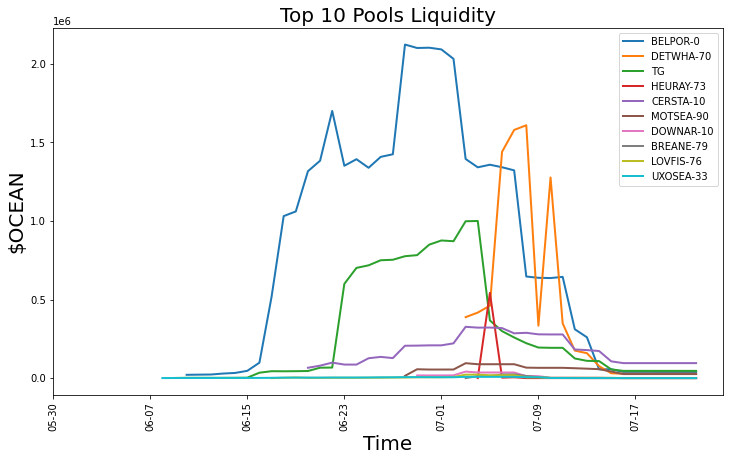

In [16]:
# plot each pool historical data
fig, ax = plt.subplots()
for pool in df_pools_sorted['id'][:10]:
    df = df_pools.loc[df_pools['id'] == pool]
    if df['datatoken.name'].unique()[0] is np.nan:
        datatoken_name = df['datatoken.name'].unique()[1]
    else:
        datatoken_name = df['datatoken.name'].unique()[0]

    if df['datatoken.symbol'].unique()[0] is np.nan:
        datatoken_symbol = df['datatoken.symbol'].unique()[1]
    else:
        datatoken_symbol = df['datatoken.symbol'].unique()[0]
    
    x = pd.to_datetime(df["timestamp"], unit='s').dt.strftime('%m-%d')

    y = df['baseTokenLiquidity'].astype(float)
    plt.plot(x, y, label = f'{datatoken_symbol}', linewidth=2)

plt.xlabel("Time", fontsize=20)
plt.ylabel("$OCEAN", fontsize=20)
plt.title(f"Top 10 Pools Liquidity", fontsize=20)
plt.xticks(rotation=30)
plt.legend(fontsize=10)

ax.tick_params(axis='x',rotation=90)

ax.set_xticks(x[0::8])

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 6.75)